In [1]:
#library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import talib
import warnings
warnings.filterwarnings('ignore')

In [2]:
#data imports
volumes = pd.read_csv('Data/stock_volumes.csv', index_col = 'date', parse_dates = True)
prices = pd.read_csv('Data/stock_prices.csv', index_col = 'date', parse_dates = True)
info = pd.read_csv('Data/stock_info.csv')
sp_listings = pd.read_csv('Data/sp500_listings.csv', index_col = 'date', parse_dates = True)

# Sample Stock

In [3]:
#select one stock
stock1 = prices[['905270']]
stock1.rename(columns = {'905270':'Price'}, inplace = True)

In [4]:
stock1.head()

,Price
date,
1990-01-02,22.75
1990-01-03,22.56
1990-01-04,22.38
1990-01-05,21.81
1990-01-08,22.25


In [5]:
#find when stock was delisted
delist_date = sp_listings.where(sp_listings['stock'] == '905270').last_valid_index() + pd.DateOffset(1)

In [6]:
sp_listings.head()

,stock
date,
1990-01-01,905270
1990-01-01,921795
1990-01-01,904261
1990-01-01,905261
1990-01-01,916328


In [7]:
#set all values after delist date to NaN
stock1.loc[delist_date:]['Price'] = np.nan

In [8]:
#drop missing values
stock1.dropna(inplace = True)

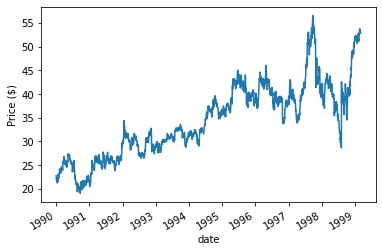

In [9]:
#EDA
stock1['Price'].plot()
plt.ylabel('Price ($)')
plt.show()

In [10]:
#Create target
stock1['10d_future_price'] = stock1['Price'].shift(-10)

In [11]:
#Create features
feature_names = []
for n in [14, 50, 200]:
    stock1['ma' + str(n)] = talib.SMA(stock1['Price'].values, timeperiod = n)/stock1['Price']
    stock1['rsi' + str(n)] = talib.RSI(stock1['Price'].values, timeperiod = n)
    feature_names += ['ma' + str(n), 'rsi' + str(n)]

In [12]:
stock1.corr()[['10d_future_price']].sort_values(by='10d_future_price', ascending = False)

,10d_future_price
10d_future_price,1.000000
Price,0.970540
rsi50,0.289926
rsi200,0.266427
rsi14,0.199373
ma14,-0.098546
ma50,-0.223523
ma200,-0.261589


In [13]:
#Drop null values
stock1.dropna(inplace = True)

In [14]:
#Create features and targets
X = stock1[feature_names]
y = stock1[['10d_future_price']]

In [15]:
#Split data into train, test
train_pct = 0.8
train_size = int(train_pct * stock1.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]

## Random Forest

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [17]:
#Random Forest
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [18]:
#Calculate R2 score
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9640603770272514
-4.184661704317636


In [19]:
# Hyperparameter Tuning
param_dist = {'n_estimators':[100, 150, 200, 250],
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'random_state': [42]}
test_scores = []

rf_tune = RandomizedSearchCV(estimator = rf,
                             param_distributions = param_dist,
                             n_jobs = -1, scoring = 'r2')

In [20]:
rf_tune.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=200), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [100, 150, 200, 250],
                                        'random_state': [42]},
                   scoring='r2')

In [21]:
rf_tune.best_params_

{'random_state': 42, 'n_estimators': 250, 'max_depth': 4}

In [22]:
rf_tune.best_score_

-8.816816216201158

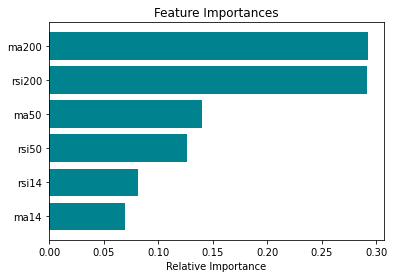

In [23]:
#Examine feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#00838fff', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Evaluation

In [24]:
#Evaluate on train set
rf_train_pred = pd.DataFrame(rf.predict(X_train))
rf_train_pred.index = y_train.index
rf_train_eval = pd.concat([y_train, rf_train_pred], axis = 1)
rf_train_eval.columns = ['actual', 'predicted']

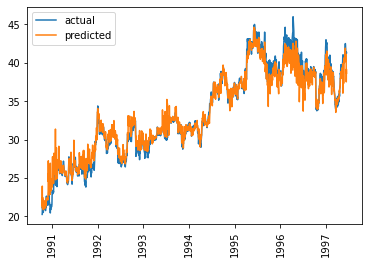

In [25]:
#Visualize
plt.plot(rf_train_eval['actual'], label = 'actual')
plt.plot(rf_train_eval['predicted'], label = 'predicted')
plt.xticks(rotation = 90)
plt.legend()

In [26]:
#Evaluate on test set
rf_test_pred = pd.DataFrame(rf.predict(X_test))
rf_test_pred.index = y_test.index
rf_test_eval = pd.concat([y_test, rf_test_pred], axis = 1)
rf_test_eval.columns = ['actual', 'predicted']

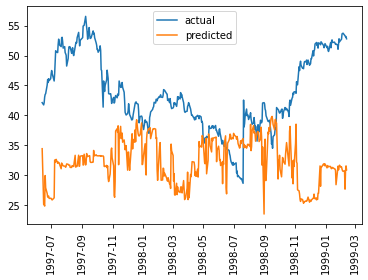

In [27]:
#Visualize
plt.plot(rf_test_eval['actual'], label = 'actual')
plt.plot(rf_test_eval['predicted'], label = 'predicted')
plt.xticks(rotation = 90)
plt.legend()

## XGBoost

In [28]:
from xgboost import XGBRegressor

In [29]:
#XGBoost Regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [30]:
#Calculate R2 score
print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))

0.9930749556381309
-4.690902302204464


### Hyperparameter Tuning

In [31]:
xgb_tune= RandomizedSearchCV(
                estimator = xgb,
                param_distributions = param_dist, 
                scoring = 'r2', 
                n_jobs = -1)

In [32]:
xgb_tune.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=8,
                                          num_parallel_tree=1, random_state=0,
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_weight=1, subsample=1,
  

In [33]:
xgb_tune.best_params_

{'random_state': 42, 'n_estimators': 100, 'max_depth': 3}

In [34]:
xgb_tune.best_score_

-12.128477522025738

### Evaluation

In [35]:
#Evaluate on train set
xgb_train_pred = pd.DataFrame(xgb.predict(X_train))
xgb_train_pred.index = y_train.index
xgb_train_eval = pd.concat([y_train, rf_train_pred], axis = 1)
xgb_train_eval.columns = ['actual', 'predicted']

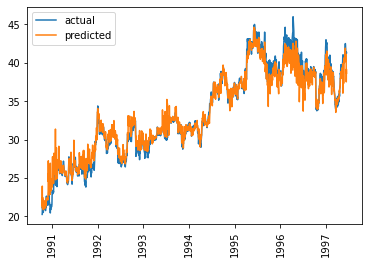

In [36]:
#Visualize
plt.plot(xgb_train_eval['actual'], label = 'actual')
plt.plot(xgb_train_eval['predicted'], label = 'predicted')
plt.xticks(rotation = 90)
plt.legend()

In [37]:
#Evaluate on test set
xgb_test_pred = pd.DataFrame(xgb.predict(X_test))
xgb_test_pred.index = y_test.index
xgb_test_eval = pd.concat([y_test, rf_test_pred], axis = 1)
xgb_test_eval.columns = ['actual', 'predicted']

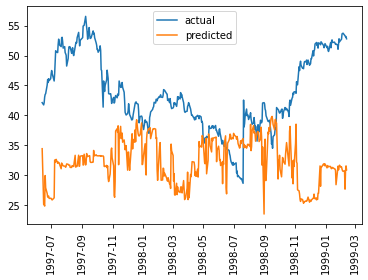

In [38]:
#Visualize
plt.plot(xgb_test_eval['actual'], label = 'actual')
plt.plot(xgb_test_eval['predicted'], label = 'predicted')
plt.xticks(rotation = 90)
plt.legend()

## Autoencoders

In [39]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

In [40]:
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [41]:
# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*2)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

In [42]:
# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [43]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 12)                84        
_________________________________________________________________
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6)                 0     

In [44]:
history = model.fit(X_train, y_train, epochs=100, verbose=2, validation_data=(X_test,y_test))

Epoch 1/100
53/53 - 1s - loss: 1143.2820 - val_loss: 1940.3805
Epoch 2/100
53/53 - 0s - loss: 1123.5601 - val_loss: 1921.3899
Epoch 3/100
53/53 - 0s - loss: 1100.6707 - val_loss: 1889.3737
Epoch 4/100
53/53 - 0s - loss: 1071.0200 - val_loss: 1830.5750
Epoch 5/100
53/53 - 0s - loss: 1033.1561 - val_loss: 1751.8157
Epoch 6/100
53/53 - 0s - loss: 984.1107 - val_loss: 1682.5280
Epoch 7/100
53/53 - 0s - loss: 924.0336 - val_loss: 1604.4006
Epoch 8/100
53/53 - 0s - loss: 856.3689 - val_loss: 1508.6049
Epoch 9/100
53/53 - 0s - loss: 783.2771 - val_loss: 1417.9636
Epoch 10/100
53/53 - 0s - loss: 705.6888 - val_loss: 1276.8579
Epoch 11/100
53/53 - 0s - loss: 629.0227 - val_loss: 1131.1543
Epoch 12/100
53/53 - 0s - loss: 552.1562 - val_loss: 1071.7997
Epoch 13/100
53/53 - 0s - loss: 476.4320 - val_loss: 1028.3683
Epoch 14/100
53/53 - 0s - loss: 407.3745 - val_loss: 963.6686
Epoch 15/100
53/53 - 0s - loss: 344.1526 - val_loss: 947.0435
Epoch 16/100
53/53 - 0s - loss: 283.5520 - val_loss: 799.5161

In [45]:
# define an encoder model (without the decoder)
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')

In [46]:
#Compressing the input data using Encoder Model and fitting it on the Logistic Regression model.
# load the model from file
encoder = load_model('encoder.h5')

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
auto_rf = RandomForestRegressor()
# fit the model on the training set
auto_rf.fit(X_train_encode, y_train)

RandomForestRegressor()

In [47]:
#Evaluate on test set
auto_test_pred = pd.DataFrame(auto_rf.predict(X_test_encode))
auto_test_pred.index = y_test.index
auto_test_eval = pd.concat([y_test, auto_test_pred], axis = 1)
auto_test_eval.columns = ['actual', 'predicted']

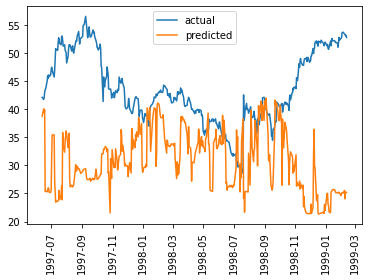

In [48]:
#Visualize
plt.plot(auto_test_eval['actual'], label = 'actual')
plt.plot(auto_test_eval['predicted'], label = 'predicted')
plt.xticks(rotation = 90)
plt.legend()

## Prophet

In [49]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [50]:
pr_df = stock1[['Price']]
pr_train = pr_df.iloc[:train_size,:]
pr_test = pr_df.iloc[train_size:,:]

In [51]:
pr_train.reset_index(inplace = True)
pr_train.rename(columns = {'date': 'ds', 'Price': 'y'}, inplace = True)

In [52]:
pr_test.reset_index(inplace = True)
pr_test.rename(columns = {'date': 'ds', 'Price': 'y'}, inplace = True)

In [53]:
pr_test

,ds,y
0,1997-06-13,41.63
1,1997-06-16,42.50
2,1997-06-17,42.50
3,1997-06-18,42.25
4,1997-06-19,41.75
...,...,...
416,1999-02-08,51.75
417,1999-02-09,51.06
418,1999-02-10,52.00
419,1999-02-11,52.81


In [54]:
pr = Prophet()

In [55]:
pr.fit(pr_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [56]:
pr_test_pred = pr.make_future_dataframe(periods=421)

In [57]:
pr_test_pred

,ds
0,1990-10-16
1,1990-10-17
2,1990-10-18
3,1990-10-19
4,1990-10-22
...,...
2100,1998-08-03
2101,1998-08-04
2102,1998-08-05
2103,1998-08-06


In [58]:
test_forecast = pr.predict(pr_test_pred)
test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2100,1998-08-03,34.014282,30.677725,37.398714
2101,1998-08-04,33.996566,30.322100,37.197236
2102,1998-08-05,34.031682,30.417660,37.584494
2103,1998-08-06,34.097795,30.787609,37.678758
2104,1998-08-07,34.060244,30.673890,37.417234


In [59]:
pr_test_eval = test_forecast.merge(pr_test, how = 'left', on = 'ds')[['ds', 'yhat', 'y', 'yhat_lower', 'yhat_upper']]

In [60]:
pr_test_eval.set_index('ds')

,yhat,y,yhat_lower,yhat_upper
ds,,,,
1990-10-16,21.682879,NaN,19.819358,23.799836
1990-10-17,21.720089,NaN,19.499759,23.662870
1990-10-18,21.791736,NaN,19.788855,23.772012
1990-10-19,21.762856,NaN,19.836389,23.824280
1990-10-22,21.807054,NaN,19.795208,23.829625
...,...,...,...,...
1998-08-03,34.014282,28.63,30.677725,37.398714
1998-08-04,33.996566,42.56,30.322100,37.197236
1998-08-05,34.031682,38.06,30.417660,37.584494


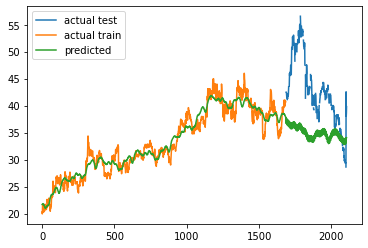

In [61]:
#Visualize
plt.plot(pr_test_eval['y'], label = 'actual test')
plt.plot(pr_train['y'], label = 'actual train')
plt.plot(pr_test_eval['yhat'], label = 'predicted')
plt.legend()

In [62]:
fig1 = pr.plot(forecast)

NameError: name 'forecast' is not defined

In [63]:
#Train accuracy
sklearn.metrics.r2_score(pr_train['y'], pr_test_eval.iloc[:train_size,:]['yhat'])

0.9294937394116489

In [64]:
#Test accuracy
sklearn.metrics.r2_score(pr_test_eval.dropna()['y'], pr_test_eval.dropna()['yhat'])

-1.303691952553979

## LSTM

In [65]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping

Code adapted from:
https://github.com/bnsreenu/python_for_microscopists/blob/master/166b-Intro_to_time_series_Forecasting_using_LSTM_and_TimeseriesGenerator.py

In [66]:
df = stock1[['Price']]

In [67]:
#Convert into numpy array
dataset = df.values

In [68]:
#Scale
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [97]:
#Train, test split
train_size_l = int(len(dataset) * 0.70)
val_size_l = int(len(dataset) * 0.15)
test_size_l = len(dataset) - train_size_l - val_size_l
train_l, val_l, test_l = dataset[0:train_size_l,:], dataset[train_size_l:val_size_l,:], dataset[val_size_l:len(dataset),:]

In [98]:
#Use TimeseriesGenerator to organize training data into the right format
seq_size = length =  10 
batch_size = 1
train_generator = TimeseriesGenerator(train_l,train_l,length=length,batch_size=batch_size)
print("Total number of samples in the original training data = ", len(train_l))
print("Total number of samples in the generated data = ", len(train_generator))

Total number of samples in the original training data =  1473
Total number of samples in the generated data =  1463


In [99]:
#Generate validation data
val_generator = TimeseriesGenerator(val_l, val_l, length = length, batch_size = batch_size)

ValueError: `start_index+length=10 > end_index=-1` is disallowed, as no part of the sequence would be left to be used as current step.

In [71]:
#Generate test data
validation_generator = TimeseriesGenerator(test_l, test_l, length=length ,batch_size=batch_size)

In [72]:
#Input dimensions are... (N x seq_size)
num_features = 1

In [73]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(length, num_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________
Train...


In [74]:
model.fit_generator(generator=train_generator, verbose=2, epochs=50, validation_data=validation_generator)

Epoch 1/50
1379/1379 - 22s - loss: 0.0028 - val_loss: 0.0023
Epoch 2/50
1379/1379 - 6s - loss: 8.4156e-04 - val_loss: 0.0042
Epoch 3/50
1379/1379 - 6s - loss: 6.4899e-04 - val_loss: 0.0016
Epoch 4/50
1379/1379 - 6s - loss: 5.1537e-04 - val_loss: 0.0015
Epoch 5/50
1379/1379 - 6s - loss: 4.7813e-04 - val_loss: 0.0010
Epoch 6/50
1379/1379 - 6s - loss: 3.9837e-04 - val_loss: 0.0011
Epoch 7/50
1379/1379 - 6s - loss: 3.5008e-04 - val_loss: 0.0012
Epoch 8/50
1379/1379 - 6s - loss: 3.4179e-04 - val_loss: 8.0620e-04
Epoch 9/50
1379/1379 - 6s - loss: 3.4369e-04 - val_loss: 7.9705e-04
Epoch 10/50
1379/1379 - 6s - loss: 2.9273e-04 - val_loss: 0.0011
Epoch 11/50
1379/1379 - 6s - loss: 2.5728e-04 - val_loss: 8.1578e-04
Epoch 12/50
1379/1379 - 6s - loss: 2.7761e-04 - val_loss: 0.0011
Epoch 13/50
1379/1379 - 6s - loss: 2.7380e-04 - val_loss: 9.4481e-04
Epoch 14/50
1379/1379 - 6s - loss: 2.5158e-04 - val_loss: 8.1980e-04
Epoch 15/50
1379/1379 - 6s - loss: 2.7205e-04 - val_loss: 7.6494e-04
Epoch 16/50
1

In [76]:
#Predict
trainPredict = model.predict(train_generator)
testPredict = model.predict(validation_generator)

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform(train_l)
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform(test_l)

In [77]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[length:len(trainPredict)+length, :] = trainPredict

In [89]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
#testPredictPlot[len(trainPredict)+(seq_size*2)-1:len(dataset)-1, :] = testPredict
testPredictPlot[len(train_l)+(length)-1:len(dataset)-1, :] = testPredict

In [90]:
# calculate R2
trainScore = sklearn.metrics.r2_score(trainY_inverse[length:], trainPredict[:,0])
print('Train Score: %.2f R2' % (trainScore))

testScore = sklearn.metrics.r2_score(testY_inverse[length:], testPredict[:,0])
print('Test Score: %.2f R2' % (testScore))

Train Score: 0.99 R2
Test Score: 0.94 R2


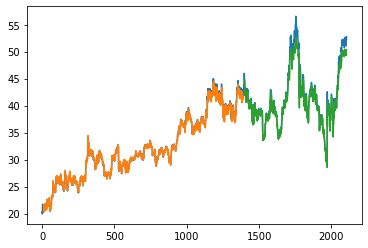

In [91]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()